In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import tensorflow as tf
if not os.path.exists("helper_functions.py"):
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
  print("[INFO] 'helper_functions.py' already exists, skipping download.")
from helper_functions import *
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')
importTensorflow(memory=4000, precision=True)

[INFO] 'helper_functions.py' already exists, skipping download.
Tensorflow version : 2.15.0
1 Physical GPU(s), 1 Logical GPU(s)
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6
Mixed precsion policy : <Policy "mixed_float16">


### Convert harder to read text into neatly classified texts(ex: research paper divided nicely into intro, backgtround, conclusion, etc)
It is a many to one RNN architecture based problem

# SKIMLIT : Milestone Project

#### Get the data

In [2]:
if not os.path.exists("pubmed_rct"):
    !git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
    !mv 'pubmed-rct' pubmed_rct
!ls ./pubmed_rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


#### Work on pubmed-20k now and scale it later

In [3]:
!ls pubmed_rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
data_dir = './pubmed_rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
filenames = [data_dir+filename for filename in os.listdir(data_dir)]
filenames

['./pubmed_rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 './pubmed_rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 './pubmed_rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [5]:
def get_lines(filepath):
    with open(filepath, 'r') as f:
        return f.readlines()
get_lines(filenames[1])[:5]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n']

In [6]:
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []
    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines=""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()

            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split)-1
                abstract_samples.append(line_data)
        else:
            abstract_lines+=line
    return abstract_samples

In [7]:
train_samples = preprocess_text_with_line_numbers(filenames[0])
val_samples = preprocess_text_with_line_numbers(filenames[1])
test_samples = preprocess_text_with_line_numbers(filenames[-1])
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [8]:
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [9]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [10]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

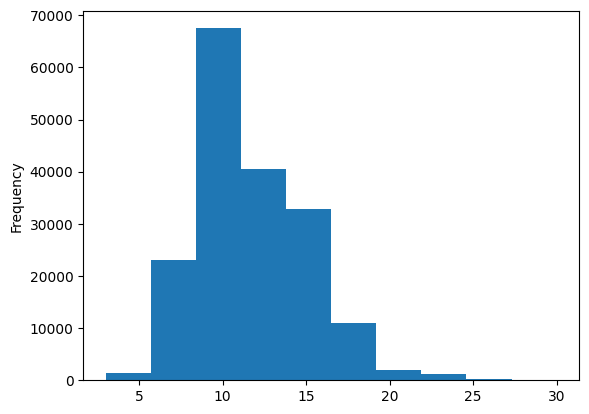

In [11]:
train_df.total_lines.plot.hist()

#### Get lists of sentences

In [12]:
train_sentences = train_df.text.to_list()
val_sentences = val_df.text.to_list()
test_sentences = test_df.text.to_list()
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [13]:
# make numeric conversion of labels/targets - method 1
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df.target.to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df.target.to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df.target.to_numpy().reshape(-1,1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [14]:
# label encoding - method 2
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df.target.to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df.target.to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df.target.to_numpy())
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [15]:
# Get class names and number of classes back from LabelEncoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

#### Model 0 - Naive Bayes

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])
model_0.fit(train_sentences, train_labels_encoded)
model_0_results = calculate_results(val_labels_encoded, model_0.predict(val_sentences))
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

#### Model 1 - Conv1D

In [17]:
# how long is each sentece of average
sent_length = [len(sentence.split()) for sentence in train_sentences]
tf.math.reduce_mean(sent_length).numpy()

26

In [18]:
# we want 95% of data to be covered, so whats the length of 95% of data
import numpy as np
int(np.percentile(sent_length, 95))

55

In [19]:
# create text vectorizer
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = 68000,
                                                output_sequence_length=55)
text_vectorizer.adapt(train_sentences)
sample_sentence = "Hi there, how are you"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[ 6193,    61,   898,    58, 10096,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])>

In [20]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [21]:
# create embedding layer
embedding = tf.keras.layers.Embedding(input_dim=68000,
                                     output_dim=128,
                                      input_length=55,
                                     mask_zero=True)
embedding(text_vectorizer([sample_sentence]))

<tf.Tensor: shape=(1, 55, 128), dtype=float16, numpy=
array([[[-0.0464  ,  0.01831 , -0.03583 , ...,  0.01566 ,  0.02835 ,
          0.03014 ],
        [-0.02924 , -0.03137 ,  0.0368  , ...,  0.00604 ,  0.02022 ,
          0.04163 ],
        [-0.006676, -0.02995 , -0.01161 , ...,  0.01341 , -0.01212 ,
          0.01903 ],
        ...,
        [-0.05    , -0.04987 ,  0.04468 , ..., -0.02286 ,  0.006268,
         -0.02667 ],
        [-0.05    , -0.04987 ,  0.04468 , ..., -0.02286 ,  0.006268,
         -0.02667 ],
        [-0.05    , -0.04987 ,  0.04468 , ..., -0.02286 ,  0.006268,
         -0.02667 ]]], dtype=float16)>

#### Creating Fast loading dataset

In [22]:
# Turn data into tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [23]:
# take tensor slice dadtaset and turn into prefetched datasets
train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [24]:
# create conv1d model
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(5, activation=tf.keras.activations.softmax)(x)

model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])
history_1 = model_1.fit(train_dataset,
                       epochs=5,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        validation_steps=int(0.1*len(val_dataset)),
                       validation_data=val_dataset)

Epoch 1/5
  3/281 [..............................] - ETA: 15s - loss: 1.5928 - accuracy: 0.3177

I0000 00:00:1703958436.575960 1568291 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


281/281 [==============================] - 10s 32ms/step - loss: 1.0357 - accuracy: 0.5938 - val_loss: 0.7177 - val_accuracy: 0.7271
Epoch 2/5
281/281 [==============================] - 3s 9ms/step - loss: 0.6802 - accuracy: 0.7452 - val_loss: 0.6413 - val_accuracy: 0.7573
Epoch 3/5
281/281 [==============================] - 2s 7ms/step - loss: 0.6351 - accuracy: 0.7640 - val_loss: 0.6187 - val_accuracy: 0.7763
Epoch 4/5
281/281 [==============================] - 2s 6ms/step - loss: 0.6078 - accuracy: 0.7788 - val_loss: 0.5920 - val_accuracy: 0.7779
Epoch 5/5
281/281 [==============================] - 2s 6ms/step - loss: 0.6069 - accuracy: 0.7853 - val_loss: 0.5818 - val_accuracy: 0.7872


In [25]:
model_1.evaluate(val_dataset)

473/473 [==============================] - 1s 2ms/step - loss: 0.5818 - accuracy: 0.7900


[0.5818474292755127, 0.7899841070175171]

In [26]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1).numpy()
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

473/473 [==============================] - 1s 1ms/step


{'accuracy': 78.9984112273269,
 'precision': 0.7905158297604842,
 'recall': 0.7899841122732689,
 'f1': 0.785391236168513}

#### Model 2 - USE - TF HUB Pretrained Feature extractor

In [27]:
import tensorflow_hub as hub
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")
embed_sample = embed([sample_sentence,
                      "When you can the unviersal sentence encider on a sentence, it turns into into numbers"])
print(embed_sample[0][:50])

tf.Tensor(
[-0.05182884 -0.04390026  0.05248979 -0.00642138  0.0454952  -0.02146592
  0.03058733 -0.07073407  0.05152308  0.04701421  0.02491418  0.00674201
 -0.03172521  0.0080713   0.00499434 -0.09463525 -0.03576988  0.0037949
 -0.04158678 -0.07285322  0.0632658  -0.01339925  0.02972649  0.04720227
 -0.06259578 -0.0154889   0.039651    0.05203718 -0.00980406  0.05468165
  0.0588766   0.0431632   0.05944403 -0.00140851 -0.01803795  0.00555375
  0.01559336 -0.03206627  0.02260791  0.02096884  0.00670307  0.02270131
  0.02106516  0.07490976  0.05131475  0.00114743 -0.09906604  0.0151604
  0.01459556  0.02136121], shape=(50,), dtype=float32)


In [28]:
# build USE model
tf_hub_embedding_layer = hub.KerasLayer(embed,
                                       trainable=False)

inputs2 = tf.keras.layers.Input(shape=[], dtype=tf.string)
x = tf_hub_embedding_layer(inputs2)
x = tf.keras.layers.Dense(128, activation=tf.keras.activations.relu)(x)
outputs2 = tf.keras.layers.Dense(5, activation=tf.keras.activations.softmax)(x)
model_2 = tf.keras.Model(inputs2, outputs2)
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])
history_2 = model_2.fit(train_dataset,
                       epochs=5,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        validation_steps=int(0.1*len(val_dataset)),
                       validation_data=val_dataset)

Epoch 1/5
281/281 [==============================] - 4s 8ms/step - loss: 0.9753 - accuracy: 0.6287 - val_loss: 0.8091 - val_accuracy: 0.6838
Epoch 2/5
281/281 [==============================] - 2s 8ms/step - loss: 0.7836 - accuracy: 0.6942 - val_loss: 0.7671 - val_accuracy: 0.7028
Epoch 3/5
281/281 [==============================] - 2s 8ms/step - loss: 0.7666 - accuracy: 0.7060 - val_loss: 0.7536 - val_accuracy: 0.7094
Epoch 4/5
281/281 [==============================] - 2s 8ms/step - loss: 0.7331 - accuracy: 0.7193 - val_loss: 0.7280 - val_accuracy: 0.7207
Epoch 5/5
281/281 [==============================] - 2s 8ms/step - loss: 0.7429 - accuracy: 0.7154 - val_loss: 0.7072 - val_accuracy: 0.7277


In [29]:
model_2_preds = tf.argmax(model_2.predict(val_dataset),axis=1).numpy()
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

473/473 [==============================] - 3s 6ms/step


{'accuracy': 72.89156626506023,
 'precision': 0.7250131044780106,
 'recall': 0.7289156626506024,
 'f1': 0.7237149364699874}

#### Model3 - Conv1D with character embedding

In [30]:
# split into characters
def split_chars(text):
    return " ".join(list(text))
split_chars(train_sentences[0])

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [31]:
#do for whole dataset
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [32]:
# avg len of chars
char_lens = [len(sentence) for sentence in train_sentences]
avg_char_len = np.mean(char_lens)
avg_char_len

149.3662574983337

In [33]:
np.percentile(char_lens, 95)

290.0

In [34]:
import string
alphabet = string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [35]:
#Create char-level token vectorizer instance
num_char_token = len(alphabet)+2
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens = num_char_token,
                                                    standardize='lower_and_strip_punctuation',
                                                output_sequence_length=290)

In [36]:
char_vectorizer.adapt(train_chars)

In [37]:
char_vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'e', 't', 'i']

In [38]:
char_vectorizer([train_chars[69]])

<tf.Tensor: shape=(1, 290), dtype=int64, numpy=
array([[17,  7,  8,  3, 19,  3, 20,  7, 14,  8,  5, 11,  3,  4, 11,  2,
         9, 17,  8,  7, 15,  3, 13,  2, 14,  2, 10,  4,  5,  3,  8,  4,
        11,  8,  2,  9,  2,  5,  8, 11, 13,  4,  6,  7, 17, 17,  4, 11,
         2,  9,  2,  3,  3,  4,  6, 18,  9,  6,  2,  3, 20,  7,  8, 23,
         7, 17,  3, 13,  2,  5, 15,  2,  8,  4, 11,  5,  6,  5, 11,  5,
        10,  2, 15, 19,  7, 17, 14,  2, 10,  4,  5,  3,  8,  4, 11,  9,
        20,  2,  8,  2,  8,  5,  6, 10,  7, 15, 12, 19,  5,  9,  9,  4,
        18,  6,  2, 10,  3,  7,  7, 17, 18,  8,  7, 16, 14,  9,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 

In [39]:
# Create a character level embedding
char_embed = tf.keras.layers.Embedding(input_dim=len(char_vectorizer.get_vocabulary()),
                                       output_dim=25,
                                       mask_zero=True)

In [40]:
char_embed(char_vectorizer([train_chars[69]]))

<tf.Tensor: shape=(1, 290, 25), dtype=float16, numpy=
array([[[-0.02577 ,  0.01113 ,  0.01134 , ...,  0.004814, -0.00887 ,
          0.01605 ],
        [-0.01602 , -0.0308  , -0.04968 , ..., -0.0281  ,  0.04675 ,
          0.02376 ],
        [-0.0203  , -0.02824 , -0.006805, ..., -0.03656 , -0.02245 ,
         -0.01636 ],
        ...,
        [ 0.00895 ,  0.04807 ,  0.04678 , ..., -0.03055 ,  0.0275  ,
         -0.01866 ],
        [ 0.00895 ,  0.04807 ,  0.04678 , ..., -0.03055 ,  0.0275  ,
         -0.01866 ],
        [ 0.00895 ,  0.04807 ,  0.04678 , ..., -0.03055 ,  0.0275  ,
         -0.01866 ]]], dtype=float16)>

In [41]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(64).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(64).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(64).prefetch(tf.data.AUTOTUNE)

In [42]:
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [43]:
# Model 3 - Conv1D with character embedding
inputs3 = tf.keras.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs3)
x = char_embed(x)
x = tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1)(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs3 = tf.keras.layers.Dense(5, activation=tf.keras.activations.softmax)(x)

model_3 =tf.keras.Model(inputs3, outputs3)
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])
history_3 = model_3.fit(train_char_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.1*len(train_char_dataset)),
                        validation_data=val_char_dataset,
                        validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/5
281/281 [==============================] - 3s 5ms/step - loss: 1.3106 - accuracy: 0.4706 - val_loss: 1.0768 - val_accuracy: 0.5678
Epoch 2/5
281/281 [==============================] - 1s 4ms/step - loss: 1.0083 - accuracy: 0.5968 - val_loss: 0.9360 - val_accuracy: 0.6300
Epoch 3/5
281/281 [==============================] - 1s 4ms/step - loss: 0.9151 - accuracy: 0.6416 - val_loss: 0.8580 - val_accuracy: 0.6682
Epoch 4/5
281/281 [==============================] - 1s 4ms/step - loss: 0.8554 - accuracy: 0.6680 - val_loss: 0.8266 - val_accuracy: 0.6825
Epoch 5/5
281/281 [==============================] - 1s 4ms/step - loss: 0.8346 - accuracy: 0.6785 - val_loss: 0.7789 - val_accuracy: 0.7008


In [44]:
model_3_preds = tf.argmax(model_3.predict(val_char_dataset), axis=1).numpy()
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

473/473 [==============================] - 1s 2ms/step


{'accuracy': 69.43598570104595,
 'precision': 0.6870529348728229,
 'recall': 0.6943598570104594,
 'f1': 0.6827579747760721}

#### Model 4 - Combine token embedding and character embeddings

In [45]:
# setup token inputs
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128,
                                     activation=tf.keras.activations.relu,
                                     name='token_outputs')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# setup char inputs
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vector = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vector)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24), name='char_bidirectional')(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

#concatenate the inputs
token_char_concat = tf.keras.layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                           char_model.output])
# create output layers - adding dropouts
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(128, activation = tf.keras.activations.relu)(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(5, activation=tf.keras.activations.softmax)(final_dropout)

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name='token_and_char_embedding')

model_4.summary()

Model: "token_and_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 290)                  0         ['char_input[0][0]']          
 Vectorization)                                                                                   
                                                                                                  
 keras_layer (KerasLayer)    (None, 512)                  2567978   ['token

In [46]:
# plot the model summary
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [47]:
# compile the model
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
# create ttensorflwo dataset for the combined input
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))
test_char_token_dataset = test_char_token_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [48]:
# fit model 4
history_4 = model_4.fit(train_char_token_dataset,
                        epochs=5,
                        validation_data=val_char_token_dataset,
                        steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                        validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/5
281/281 [==============================] - 14s 26ms/step - loss: 1.0378 - accuracy: 0.5895 - val_loss: 0.8083 - val_accuracy: 0.6898
Epoch 2/5
281/281 [==============================] - 6s 21ms/step - loss: 0.8256 - accuracy: 0.6783 - val_loss: 0.7382 - val_accuracy: 0.7214
Epoch 3/5
281/281 [==============================] - 5s 19ms/step - loss: 0.7812 - accuracy: 0.7029 - val_loss: 0.7037 - val_accuracy: 0.7301
Epoch 4/5
281/281 [==============================] - 6s 22ms/step - loss: 0.7543 - accuracy: 0.7137 - val_loss: 0.6805 - val_accuracy: 0.7380
Epoch 5/5
281/281 [==============================] - 5s 20ms/step - loss: 0.7591 - accuracy: 0.7121 - val_loss: 0.6674 - val_accuracy: 0.7463


In [49]:
#evaluate
model_4.evaluate(val_char_token_dataset)

473/473 [==============================] - 4s 8ms/step - loss: 0.6752 - accuracy: 0.7434


[0.6752440333366394, 0.7434462904930115]

In [50]:
model_4_preds = tf.argmax(model_4.predict(val_char_token_dataset), axis=1).numpy()
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

473/473 [==============================] - 5s 8ms/step


{'accuracy': 74.34463127234213,
 'precision': 0.7411509664792942,
 'recall': 0.7434463127234212,
 'f1': 0.738486927441179}

#### Model 5 - Token embeddings + character embeddings + positional embeddings

maybe use line numbers for embeddings for better training

In [51]:
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


Any engineered features usd to train the model need to be available at test time, in our case, line number and total number of lines needs to be available

In [52]:
# How many different line numbers are there
train_df.line_number.value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

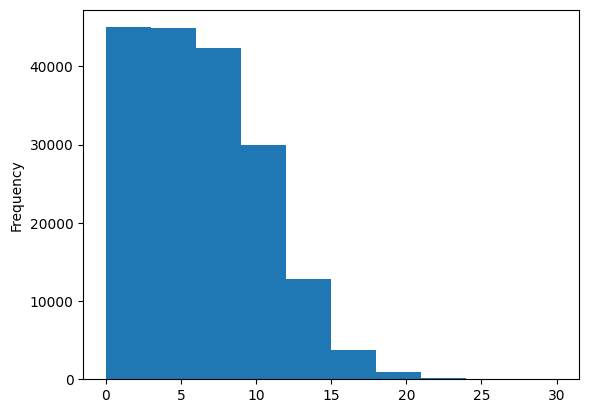

In [53]:
# check distribution of line_numbers column
train_df.line_number.plot.hist()

In [54]:
# use tensorflow to create one hot encoded tensors of line_numbers
train_line_numbers_one_hot = tf.one_hot(train_df.line_number.to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df.line_number.to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df.line_number.to_numpy(), depth=15)
train_line_numbers_one_hot[:10]

<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

(total_lines
 11    24468
 10    23639
 12    22113
 9     19400
 13    18438
 14    14610
 8     12285
 15    10768
 7      7464
 16     7429
 17     5202
 6      3353
 18     3344
 19     2480
 20     1281
 5      1146
 21      770
 22      759
 23      264
 4       215
 24      200
 25      182
 26       81
 28       58
 3        32
 30       31
 27       28
 Name: count, dtype: int64,
 18.0)

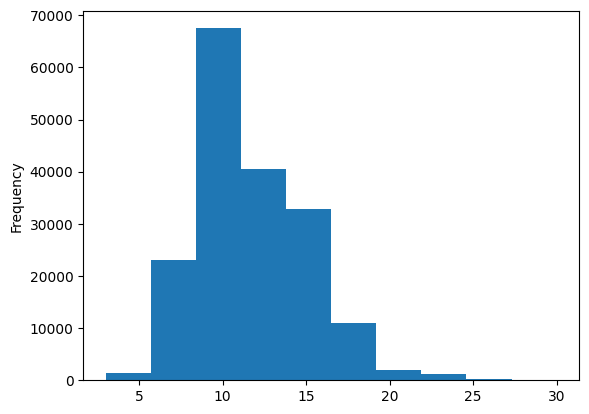

In [55]:
train_df.total_lines.plot.hist()
train_df.total_lines.value_counts(), np.percentile(train_df.total_lines, 95)

In [56]:
# use tensorflow to one hot encode tensors
train_total_line_one_hot = tf.one_hot(train_df.total_lines.to_numpy(), depth=20)
val_total_line_one_hot = tf.one_hot(val_df.total_lines.to_numpy(), depth=20)
test_total_line_one_hot = tf.one_hot(test_df.total_lines.to_numpy(), depth=20)
train_total_line_one_hot[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

#### build model 5 - tribrid embedding model
1. Build a token level model
2. Build a character level model
3. Build a model for "line_numbers" feature
4. Build a model for "total_lines" feature
5. Concatenate mdoel 1 & 2
6. Concatenate model 3, 4 & 5
7. Create output layer that accepts tribed input and gives output label probabilities
8. Combine the inputs of 1, 2, 3 & 4 and outputs of 7 into a model

In [57]:
# setup token level model
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation=tf.keras.activations.relu, name='token_output')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)

# setup character level model
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vector = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vector)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24), name='char_bi_lstm')(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

#setup model for line_number feature
line_number_input = tf.keras.layers.Input(shape=(15, ), dtype=tf.float32, name='line_number_inputs')
line_number_dense = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu, name='line_number_dense')(line_number_input)
line_number_model = tf.keras.Model(inputs = line_number_input,
                                   outputs = line_number_dense)

#setup model for total_lines feature
total_lines_input = tf.keras.layers.Input(shape=(20, ), dtype=tf.float32, name='total_lines_input')
total_lines_dense = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu, name='total_lines_dense')(total_lines_input)
total_lines_model = tf.keras.Model(inputs=total_lines_input,
                                  outputs = total_lines_dense)

#concatenate token and char embeddings
token_char_concat = tf.keras.layers.Concatenate(name='token_char_concat')([token_model.output,
                                                                           char_model.output])
token_char_dense = tf.keras.layers.Dense(256, activation=tf.keras.activations.relu)(token_char_concat)
token_char_dropout = tf.keras.layers.Dropout(0.5)(token_char_dense)

#concatenate previous concatenated layer with features
all_concat = tf.keras.layers.Concatenate(name='all_inputs_concatenate')([line_number_model.output, total_lines_model.output, token_char_dropout])

# create output layer that accepts tribed input
output_layer = tf.keras.layers.Dense(5, activation=tf.keras.activations.softmax)(all_concat)

model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                             outputs = output_layer,
                             name='tribid_model')
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # reduces overfitting in label probability predictions
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_5.summary()

Model: "tribid_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 290)                  0         ['char_input[0][0]']          
 Vectorization)                                                                                   
                                                                                                  
 keras_layer (KerasLayer)    (None, 512)                  2567978   ['token_input[0][0]

In [58]:
from keras.utils import plot_model
plot_model(model_5, show_shapes=True, show_dtype=True, expand_nested=True, show_layer_activations=True, dpi=75)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [59]:
# Create data API for multi inputs
train_all_dataset_x = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, train_total_line_one_hot, train_sentences, train_chars))
train_all_dataset_y = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_all_dataset = tf.data.Dataset.zip((train_all_dataset_x, train_all_dataset_y)).batch(64).prefetch(tf.data.AUTOTUNE)

val_all_dataset_x = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, val_total_line_one_hot, val_sentences, val_chars))
val_all_dataset_y = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_all_dataset = tf.data.Dataset.zip((val_all_dataset_x, val_all_dataset_y)).batch(64).prefetch(tf.data.AUTOTUNE)

test_all_dataset_x = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot, test_total_line_one_hot, test_sentences, test_chars))
test_all_dataset_y = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_all_dataset = tf.data.Dataset.zip((test_all_dataset_x, test_all_dataset_y)).batch(64).prefetch(tf.data.AUTOTUNE)

train_all_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [60]:
# Fit the model
history_5 = model_5.fit(train_all_dataset,
                        epochs=5,
                        validation_data=val_all_dataset,
                        steps_per_epoch=int(0.1*len(train_all_dataset)),
                        validation_steps=int(0.1*len(val_all_dataset)))

Epoch 1/5
281/281 [==============================] - 14s 27ms/step - loss: 1.1457 - accuracy: 0.6904 - val_loss: 1.0025 - val_accuracy: 0.7959
Epoch 2/5
281/281 [==============================] - 6s 21ms/step - loss: 0.9835 - accuracy: 0.8049 - val_loss: 0.9587 - val_accuracy: 0.8178
Epoch 3/5
281/281 [==============================] - 5s 19ms/step - loss: 0.9605 - accuracy: 0.8165 - val_loss: 0.9486 - val_accuracy: 0.8258
Epoch 4/5
281/281 [==============================] - 6s 22ms/step - loss: 0.9471 - accuracy: 0.8298 - val_loss: 0.9358 - val_accuracy: 0.8308
Epoch 5/5
281/281 [==============================] - 6s 21ms/step - loss: 0.9421 - accuracy: 0.8324 - val_loss: 0.9283 - val_accuracy: 0.8391


In [61]:
# make predictions
model_5_preds = tf.argmax(model_5.predict(val_all_dataset), axis=1).numpy()
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

473/473 [==============================] - 5s 8ms/step


{'accuracy': 84.11889315503774,
 'precision': 0.8453193840600012,
 'recall': 0.8411889315503773,
 'f1': 0.8370127856219338}

#### Compare model results

In [62]:
#Combine model results into data frame
all_model_results = pd.DataFrame({"model_0_baseline":model_0_results,
                                  "model_1_custom_token_embedding":model_1_results,
                                  "model_2_pretrained_token_embedding":model_2_results,
                                  "model_3_char_embedding":model_3_results,
                                  "model_4_hybrid_token_char_embedding":model_4_results,
                                  "model_5_hybrid_token_char_positional_embedding":model_5_results})
all_model_results = all_model_results.transpose()
all_model_results.accuracy = all_model_results.accuracy/100
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embedding,0.792864,0.792702,0.792864,0.788573
model_2_pretrained_token_embedding,0.723554,0.719486,0.723554,0.717960
model_3_char_embedding,0.694360,0.687053,0.694360,0.682758
model_4_hybrid_token_char_embedding,0.743446,0.741151,0.743446,0.738487
model_5_hybrid_token_char_positional_embedding,0.841189,0.845319,0.841189,0.837013


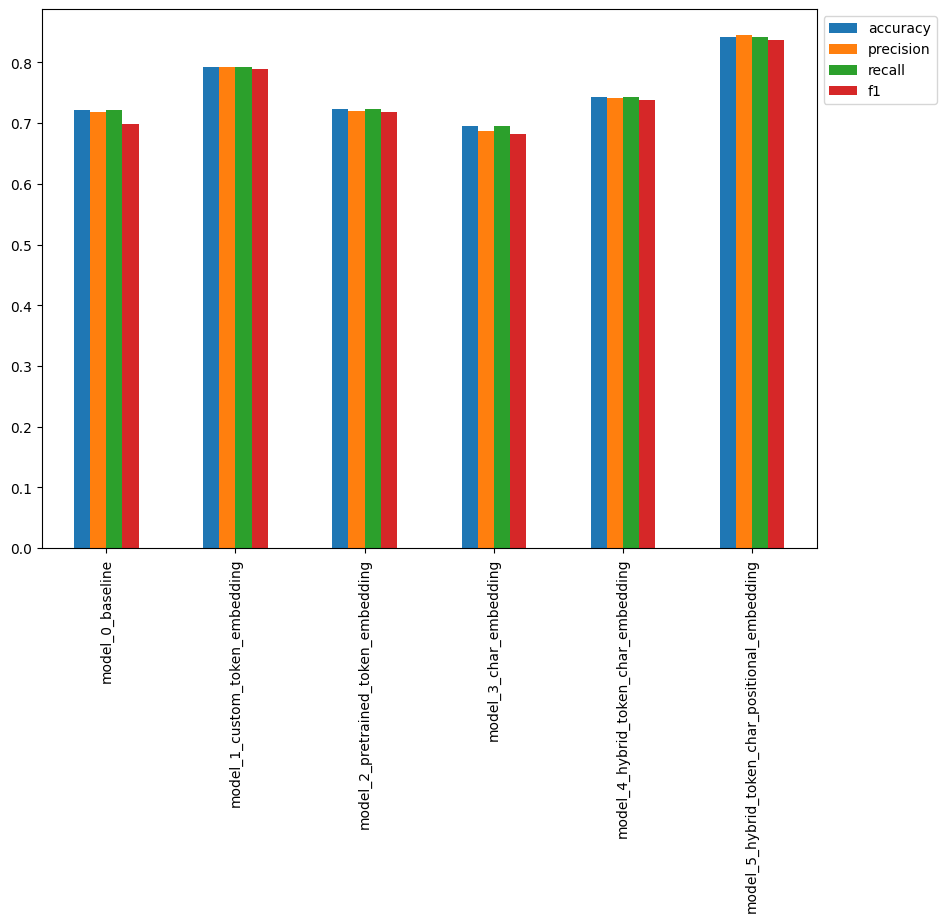

In [63]:
all_model_results.plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0))

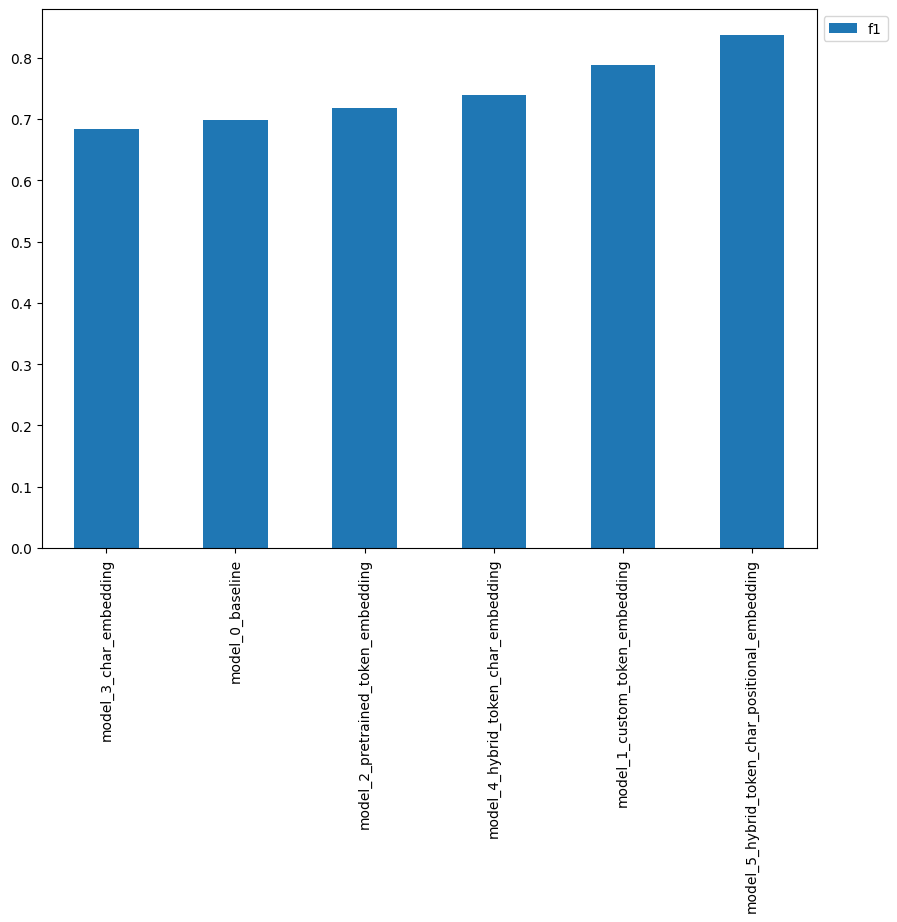

In [64]:
# get f1 score
all_model_results.sort_values("f1", ascending=True).f1.plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0))

In [65]:
# save the model
model_5.save("skimlit_tribrid_model_10percent")

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e04cae20>, 140643056916480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e04cae20>, 140643056916480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e04dfe80>, 140643056916880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e04dfe80>, 140643056916880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(25, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e04f1e80>, 140643056506560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(25, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e04f1e80>, 140643056506560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0484e80>, 140643056506896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0484e80>, 140643056506896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0496ee0>, 140643056504992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0496ee0>, 140643056504992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(25, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e04a9ee0>, 140643056506112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(25, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e04a9ee0>, 140643056506112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e043cee0>, 140643056507456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e043cee0>, 140643056507456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e044cf40>, 140643056506784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e044cf40>, 140643056506784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(176, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0460f40>, 140643013540560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(176, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0460f40>, 140643013540560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0473fa0>, 140643013541040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0473fa0>, 140643013541040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(15, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0406fa0>, 140643016568880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(15, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0406fa0>, 140643016568880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0429040>, 140643016570080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0429040>, 140643016570080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e03ba040>, 140643013515344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e03ba040>, 140643013515344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e03cd0a0>, 140643013515744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e03cd0a0>, 140643013515744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(320, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e03df0a0>, 140643013573008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(320, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e03df0a0>, 140643013573008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e03f0100>, 140643013573488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e03f0100>, 140643013573488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b824f220>, 140643056916480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b824f220>, 140643056916480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b825b220>, 140643056916880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b825b220>, 140643056916880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(25, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b826d1c0>, 140643056506560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(25, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b826d1c0>, 140643056506560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b8202160>, 140643056506896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b8202160>, 140643056506896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b8212160>, 140643056504992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b8212160>, 140643056504992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(25, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b8225100>, 140643056506112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(25, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b8225100>, 140643056506112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b81bf0a0>, 140643056507456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b81bf0a0>, 140643056507456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b81d30a0>, 140643056506784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b81d30a0>, 140643056506784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(176, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea0388d310>, 140643013540560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(176, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea0388d310>, 140643013540560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea038897f0>, 140643013541040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea038897f0>, 140643013541040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(15, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea038997f0>, 140643016568880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(15, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea038997f0>, 140643016568880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea0386bee0>, 140643016570080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea0386bee0>, 140643016570080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea00dca670>, 140643013515344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea00dca670>, 140643013515344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea00522cd0>, 140643013515744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea00522cd0>, 140643013515744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(320, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea005565e0>, 140643013573008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(320, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea005565e0>, 140643013573008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea00458b20>, 140643013573488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea00458b20>, 140643013573488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e04cae20>, 140643056916480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e04cae20>, 140643056916480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e04dfe80>, 140643056916880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e04dfe80>, 140643056916880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(25, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e04f1e80>, 140643056506560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(25, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e04f1e80>, 140643056506560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0484e80>, 140643056506896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0484e80>, 140643056506896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0496ee0>, 140643056504992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0496ee0>, 140643056504992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(25, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e04a9ee0>, 140643056506112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(25, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e04a9ee0>, 140643056506112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e043cee0>, 140643056507456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e043cee0>, 140643056507456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e044cf40>, 140643056506784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e044cf40>, 140643056506784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(176, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0460f40>, 140643013540560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(176, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0460f40>, 140643013540560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0473fa0>, 140643013541040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0473fa0>, 140643013541040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(15, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0406fa0>, 140643016568880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(15, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0406fa0>, 140643016568880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0429040>, 140643016570080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e0429040>, 140643016570080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e03ba040>, 140643013515344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e03ba040>, 140643013515344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e03cd0a0>, 140643013515744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e03cd0a0>, 140643013515744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(320, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e03df0a0>, 140643013573008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(320, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e03df0a0>, 140643013573008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e03f0100>, 140643013573488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9e03f0100>, 140643013573488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b824f220>, 140643056916480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b824f220>, 140643056916480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b825b220>, 140643056916880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b825b220>, 140643056916880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(25, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b826d1c0>, 140643056506560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(25, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b826d1c0>, 140643056506560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b8202160>, 140643056506896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b8202160>, 140643056506896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b8212160>, 140643056504992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b8212160>, 140643056504992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(25, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b8225100>, 140643056506112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(25, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b8225100>, 140643056506112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b81bf0a0>, 140643056507456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b81bf0a0>, 140643056507456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b81d30a0>, 140643056506784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe9b81d30a0>, 140643056506784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(176, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea0388d310>, 140643013540560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(176, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea0388d310>, 140643013540560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea038897f0>, 140643013541040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea038897f0>, 140643013541040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(15, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea038997f0>, 140643016568880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(15, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea038997f0>, 140643016568880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea0386bee0>, 140643016570080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea0386bee0>, 140643016570080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea00dca670>, 140643013515344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea00dca670>, 140643013515344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea00522cd0>, 140643013515744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea00522cd0>, 140643013515744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(320, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea005565e0>, 140643013573008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(320, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea005565e0>, 140643013573008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea00458b20>, 140643013573488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fea00458b20>, 140643013573488), {}).


INFO:tensorflow:Assets written to: skimlit_tribrid_model_10percent/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model_10percent/assets


In [66]:
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model_10percent")
loaded_model.summary()

Model: "tribid_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 290)                  0         ['char_input[0][0]']          
 Vectorization)                                                                                   
                                                                                                  
 keras_layer (KerasLayer)    (None, 512)                  2567978   ['token_input[0][0]

In [67]:
loaded_model_preds = tf.argmax(loaded_model.predict(val_all_dataset), axis=1).numpy()
loaded_model_result = calculate_results(val_labels_encoded, loaded_model_preds)
loaded_model_result

473/473 [==============================] - 7s 9ms/step


{'accuracy': 84.11889315503774,
 'precision': 0.8453193840600012,
 'recall': 0.8411889315503773,
 'f1': 0.8370127856219338}

In [68]:
model_5_results

{'accuracy': 84.11889315503774,
 'precision': 0.8453193840600012,
 'recall': 0.8411889315503773,
 'f1': 0.8370127856219338}

## Exercise

In [69]:
# 1. Train model_5 on all of the data in the training dataset for as many epochs until it stops improving.
#lets compile the model again(this time with some callbacks)

#callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='model_5_entire/',
                                                      verbose=1,
                                                      save_best_only=True,
                                                      save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3,
                                                  verbose=1,
                                                  restore_best_weights=True,
                                                  min_delta=0.001)

# setup token level model
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation=tf.keras.activations.relu, name='token_output')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)

# setup character level model
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vector = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vector)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24), name='char_bi_lstm')(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

#setup model for line_number feature
line_number_input = tf.keras.layers.Input(shape=(15, ), dtype=tf.float32, name='line_number_inputs')
line_number_dense = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu, name='line_number_dense')(line_number_input)
line_number_model = tf.keras.Model(inputs = line_number_input,
                                   outputs = line_number_dense)

#setup model for total_lines feature
total_lines_input = tf.keras.layers.Input(shape=(20, ), dtype=tf.float32, name='total_lines_input')
total_lines_dense = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu, name='total_lines_dense')(total_lines_input)
total_lines_model = tf.keras.Model(inputs=total_lines_input,
                                  outputs = total_lines_dense)

#concatenate token and char embeddings
token_char_concat = tf.keras.layers.Concatenate(name='token_char_concat')([token_model.output,
                                                                           char_model.output])
token_char_dense = tf.keras.layers.Dense(256, activation=tf.keras.activations.relu)(token_char_concat)
token_char_dropout = tf.keras.layers.Dropout(0.5)(token_char_dense)

#concatenate previous concatenated layer with features
all_concat = tf.keras.layers.Concatenate(name='all_inputs_concatenate')([line_number_model.output, total_lines_model.output, token_char_dropout])

# create output layer that accepts tribed input
output_layer = tf.keras.layers.Dense(5, activation=tf.keras.activations.softmax)(all_concat)

model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                             outputs = output_layer,
                             name='tribid_model')
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # reduces overfitting in label probability predictions
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_5_exercise = model_5.fit(train_all_dataset,
                                 epochs=100,
                                 validation_data=val_all_dataset,
                                 validation_steps=int(0.1*len(val_all_dataset)),
                                 callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
2814/2814 [==============================] - ETA: 0s - loss: 0.9629 - accuracy: 0.8161
Epoch 1: val_loss improved from inf to 0.91589, saving model to model_5_entire/
2814/2814 [==============================] - 69s 23ms/step - loss: 0.9629 - accuracy: 0.8161 - val_loss: 0.9159 - val_accuracy: 0.8428
Epoch 2/100
2812/2814 [============================>.] - ETA: 0s - loss: 0.9088 - accuracy: 0.8542
Epoch 2: val_loss improved from 0.91589 to 0.90174, saving model to model_5_entire/
2814/2814 [==============================] - 63s 22ms/step - loss: 0.9088 - accuracy: 0.8542 - val_loss: 0.9017 - val_accuracy: 0.8517
Epoch 3/100
2812/2814 [============================>.] - ETA: 0s - loss: 0.8956 - accuracy: 0.8632
Epoch 3: val_loss improved from 0.90174 to 0.89771, saving model to model_5_entire/
2814/2814 [==============================] - 65s 23ms/step - loss: 0.8956 - accuracy: 0.8632 - val_loss: 0.8977 - val_accuracy: 0.8541
Epoch 4/100
2812/2814 [===========================

In [70]:
#make predictions and compare
model_5_exercise_preds = tf.argmax(model_5.predict(val_all_dataset), axis=1).numpy()
model_5_exercise_results = calculate_results(val_labels_encoded, model_5_exercise_preds)
model_5_exercise_results

473/473 [==============================] - 6s 10ms/step


{'accuracy': 85.80365417714815,
 'precision': 0.859789857897737,
 'recall': 0.8580365417714815,
 'f1': 0.8548051302688578}

In [71]:
#2. Checkout the Keras guide on using pretrained GloVe embeddings. Can you get this working with one of our models?
if not os.path.exists("glove.6B.zip"):
    !wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
    !unzip -q glove.6B.zip

path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))
voc = char_vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

--2023-12-28 17:29:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.99MB/s    in 3m 23s  

2023-12-28 17:33:21 (4.06 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Found 400000 word vectors.


In [72]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

Converted 26 words (2 misses)


In [73]:
inputs_exercise = tf.keras.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs_exercise)
x = embedding_layer(x)
x = tf.keras.layers.Conv1D(filters=128, kernel_size=5)(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs_exercise = tf.keras.layers.Dense(5, activation=tf.keras.activations.softmax)(x)

model_exercise_2 =tf.keras.Model(inputs_exercise, outputs_exercise)
model_exercise_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])
history_exercise_2 = model_exercise_2.fit(train_char_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.1*len(train_char_dataset)),
                        validation_data=val_char_dataset,
                        validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/5
281/281 [==============================] - 2s 5ms/step - loss: 1.1235 - accuracy: 0.5572 - val_loss: 0.9439 - val_accuracy: 0.6220
Epoch 2/5
281/281 [==============================] - 1s 4ms/step - loss: 0.9283 - accuracy: 0.6353 - val_loss: 0.8430 - val_accuracy: 0.6735
Epoch 3/5
281/281 [==============================] - 1s 4ms/step - loss: 0.8790 - accuracy: 0.6610 - val_loss: 0.8110 - val_accuracy: 0.6885
Epoch 4/5
281/281 [==============================] - 1s 4ms/step - loss: 0.8249 - accuracy: 0.6843 - val_loss: 0.7818 - val_accuracy: 0.7028
Epoch 5/5
281/281 [==============================] - 1s 4ms/step - loss: 0.8129 - accuracy: 0.6839 - val_loss: 0.7744 - val_accuracy: 0.7094


In [74]:
model_exercise_2_preds = tf.argmax(model_exercise_2.predict(val_char_dataset), axis=1).numpy()
model_exercise_2_results = calculate_results(val_labels_encoded, model_exercise_2_preds)
model_exercise_2_results

473/473 [==============================] - 1s 2ms/step


{'accuracy': 69.98874619356546,
 'precision': 0.7187402289630447,
 'recall': 0.6998874619356547,
 'f1': 0.703681555916045}

In [75]:
model_3_results

{'accuracy': 69.43598570104595,
 'precision': 0.6870529348728229,
 'recall': 0.6943598570104594,
 'f1': 0.6827579747760721}

In [76]:
#3. Try replacing the TensorFlow Hub Universal Sentence Encoder pretrained embedding for the TensorFlow Hub
# BERT PubMed expert (a language model pretrained on PubMed texts) pretrained embedding. Does this effect results?
# !pip install --quiet tensorflow-text
# tf.compat.v1.register_op('CaseFoldUTF8')
# preprocess = hub.load('https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3')
# bert = hub.load('https://www.kaggle.com/models/google/experts-bert/frameworks/TensorFlow2/variations/pubmed/versions/2')
# bert_inputs = preprocess(train_sentences)
# bert_outputs = bert(bert_inputs, training=False)
# pooled_output = bert_outputs['pooled_output']
# sequence_output = bert_outputs['sequence_output']
# sequence_outputs

In [77]:
#4. What happens if you were to merge our line_number and total_lines features for each sequence?
# For example, created a X_of_Y feature instead? Does this effect model performance?
# train_df_exercise = train_df
# train_df_exercise['lines'] = train_df_exercise.line_number.astype(str)+"_of_"+train_df_exercise.total_lines.astype(str)

# val_df_exercise = val_df
# val_df_exercise['lines'] = val_df_exercise.line_number.astype(str)+"_of_"+val_df_exercise.total_lines.astype(str)

# test_df_exercise = test_df
# test_df_exercise['lines'] = test_df_exercise.line_number.astype(str)+"_of_"+test_df_exercise.total_lines.astype(str)

# train_df_exercise.head()

In [78]:
#5. Write a function (or series of functions) to take a sample abstract string, preprocess it (in the same way our model has been trained),
# make a prediction on each sequence in the abstract and return the abstract
sentence="Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world. There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence. Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD). Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis. The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients. Any patient with HCV infection was selected for this analysis. Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t.i.d. and 12 received placebo for 12-weeks. With respect to the placebo group (3/12, 25.0%), a significantly higher number of patients who achieved and maintained total alcohol abstinence was found in the baclofen group (10/12, 83.3%; p=0.0123). Furthermore, in the baclofen group, compared to placebo, there was a significantly higher increase in albumin values from baseline (p=0.0132) and a trend toward a significant reduction in INR levels from baseline (p=0.0716). In conclusion, baclofen was safe and significantly more effective than placebo in promoting alcohol abstinence, and improving some Liver Function Tests (LFTs) (i.e. albumin, INR) in alcohol-dependent HCV-infected cirrhotic patients. Baclofen may represent a clinically relevant alcohol pharmacotherapy for these patients."
sentence = sentence.strip().split(". ")
char_test = [split_chars(line) for line in sentence]
line_number_test = [i for i in range(len(sentence))]
total_lines_test = len(sentence)
test_df_exercise = pd.DataFrame({"text":sentence,
                                 "line_number":line_number_test,
                                 "total_lines":total_lines_test})
test_df_exercise

,text,line_number,total_lines
0,Hepatitis C virus (HCV) and alcoholic liver di...,0,13
1,There is no safe level of drinking in HCV-infe...,1,13
2,"Baclofen, a GABA(B) receptor agonist, represen...",2,13
3,"Previously, we performed a randomized clinical...",3,13
4,The goal of this post-hoc analysis was to expl...,4,13
5,Any patient with HCV infection was selected fo...,5,13
6,Among the 84 subjects randomized in the main t...,6,13
7,and 12 received placebo for 12-weeks,7,13
8,"With respect to the placebo group (3/12, 25.0%...",8,13
9,"Furthermore, in the baclofen group, compared t...",9,13


In [79]:
val_all_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [80]:
test_sentences=test_df_exercise.text
test_line_number=test_df_exercise.line_number
test_total_lines=test_df_exercise.total_lines

test_chars = [split_chars(sentence) for sentence in test_sentences]

In [81]:
test_total_lines_one_hot = tf.one_hot(test_df_exercise.total_lines.to_numpy(), depth=14)
test_line_numbers_one_hot = tf.one_hot(test_df_exercise.line_number.to_numpy(), depth=13)

In [82]:
test_all_dataset_exercise = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot, test_total_lines_one_hot, test_sentences, test_chars))
test_all_dataset_exercise

<_TensorSliceDataset element_spec=(TensorSpec(shape=(13,), dtype=tf.float32, name=None), TensorSpec(shape=(14,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [83]:
# model_5.predict(test_all_dataset_exercise)